In [1]:
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Build and Merge Dataset

There are 12 datasets given as part of the challenge.
For validation purpose, datasets 1 - 11 are used as train data and dataset 12 is used as test data.

As this approach will make use of all 3 sensors readings, aggregation of data needs to be done.
After discussion with Silver Rail representative, 1 second is a reasonable interval to tolerate error that may
appear within it because the recorded reading interval is set at 5ms.

Datasets are merged on rounded 'TI' column and combined by taking the mean of values within the interval.

# Merging script

#========================================================================================================

#For assigning mode value when merging by TI

def conv(num):
    return 0 if num < 0.5 else 1

nfiles = 10

for nfile in range(1, nfiles+1):
    print(nfile)
    df_acc = pd.read_csv(f"./data/dataset{nfile}/Accelerometer.csv")
    df_gyr = pd.read_csv(f"./data/dataset{nfile}/Gyroscope.csv")
    df_mag = pd.read_csv(f"./data/dataset{nfile}/Magnetometer.csv")

    df_acc = df_acc[df_acc['mode'] != 'Bus']
    df_gyr= df_gyr[df_gyr['mode'] != 'Bus']
    df_mag = df_mag[df_mag['mode'] != 'Bus']

    df_acc.dropna(inplace=True)
    df_gyr.dropna(inplace=True)
    df_mag.dropna(inplace=True)

    df_acc = df_acc.drop(columns=["TS"]).replace({'mode': {'Train': 1, 'Walking': 0}})
    df_gyr = df_gyr.drop(columns=["TS"]).replace({'mode': {'Train': 1, 'Walking': 0}})
    df_mag = df_mag.drop(columns=["TS"]).replace({'mode': {'Train': 1, 'Walking': 0}})

    df_acc['TI'] = df_acc['TI'].apply(lambda x: math.floor(x))
    df_gyr['TI'] = df_gyr['TI'].apply(lambda x: math.floor(x))
    df_mag['TI'] = df_mag['TI'].apply(lambda x: math.floor(x))

    merged_df = df_acc.merge(df_gyr.merge(df_mag, on=['TI']), on=['TI'])
    merged_df.columns = ['TI', 'acc_x', 'acc_y', 'acc_z', 'acc_mode', 'gyr_x', 'gyr_y', 'gyr_z', 'gyr_mode', \
                         'mag_x', 'mag_y', 'mag_z', 'mag_mode']
    merged_df['mode'] = merged_df[['acc_mode', 'gyr_mode', 'mag_mode']].mean(axis=1)

    merged_df = merged_df.groupby(['TI'], as_index=False).mean()

    print(merged_df['mode'].unique())
    merged_df['mode'] = merged_df[['acc_mode', 'gyr_mode', 'mag_mode']].mean(axis=1)
    merged_df['mode'] = merged_df['mode'].apply(lambda x: conv(x))
    print(merged_df['mode'].unique())

    merged_df.drop(columns=['TI', 'acc_mode', 'gyr_mode', 'mag_mode'], inplace=True)

    merged_df.to_csv(f"./datamerged_df{nfile}.csv", index=False)
    
    gc.collect()
    print("=================================")

The files are later concatenated after merging accelerometer, gyroscope and magnetometer into a single file.

#========================================================================================================

df_merge1 = pd.read_csv("./data/merged_df1.csv")
df_merge2 = pd.read_csv("./data/merged_df2.csv")
df_merge3 = pd.read_csv("./data/merged_df3.csv")
df_merge4 = pd.read_csv("./data/merged_df4.csv")
df_merge5 = pd.read_csv("./data/merged_df5.csv")
df_merge6 = pd.read_csv("./data/merged_df6.csv")
df_merge7 = pd.read_csv("./data/merged_df7.csv")
df_merge8 = pd.read_csv("./data/merged_df8.csv")
df_merge9 = pd.read_csv("./data/merged_df9.csv")
df_merge10 = pd.read_csv("./data/merged_df10.csv")
df_merge11_1 = pd.read_csv("./data/merged_df11_1.csv")
df_merge11_2 = pd.read_csv("./data/merged_df11_2.csv")


df_res = pd.concat([df_merge1, df_merge2, df_merge3, df_merge4, df_merge5, df_merge6, df_merge7, df_merge8, df_merge9, df_merge10])
df_res.to_csv("./data/clean_merged_1_11_0.5.csv", index=False)

# Reading in merged data

In [2]:
train_df = pd.read_csv("./data/clean_merged_1_11_0.5.csv")

In [3]:
train_df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,mode
0,0.192784,-0.480037,-0.839129,-0.474434,-0.268126,0.283632,127.769066,12.484465,-772.170809,1
1,-0.078466,-0.026469,-0.996841,-0.111714,-0.246666,-0.244131,100.514932,29.385223,-775.509803,1
2,-0.051055,-0.108133,-0.997823,0.081890,0.113779,-0.092978,96.297213,34.125927,-770.516082,1
3,-0.010501,-0.128384,-1.008556,0.020765,-0.093513,0.003766,97.242038,34.374825,-770.246047,1
4,-0.011499,-0.128213,-1.016252,0.022095,-0.094202,0.004144,97.645691,34.346363,-770.386385,1


# Data Exploration

Scatter plots between features and mode are important.

The following plots if indicate much overlap between both feature (readings) of mode 0 and 1, is bad because
it is harder to discriminate mode by using the feature.

Aggregated values seem to alleviate slightly the problem of overlap but there are much to be done.

Interestingly enough Accelerometer and Gyroscope seems to be biased towards 'Walk' (wider range) whereas 
Magnetometer is biased towards 'Train'. 

It maybe intuitive to see that when a person is walking, the movement tend to be stronger and less likely 
to make a huge change of orientation (tend to walk straight) as indicated by high dependence on Accelerometer
and less so on Magnetometer.

For the case for being on a train, it will be the other way round and high dependence on Magnetometer might have
been an evidence for this hypothesis.

## Overlap between readings of mode 0 and 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f424875c198>],
      dtype=object)

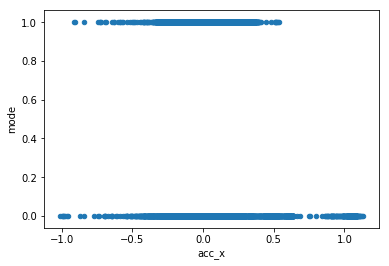

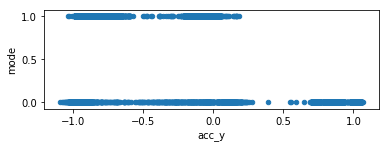

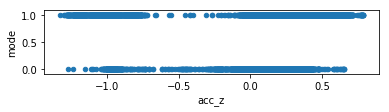

In [4]:
train_df.plot(x='acc_x', y='mode', kind='scatter',subplots=True, layout=(1,1))
train_df.plot(x='acc_y', y='mode', kind='scatter',subplots=True, layout=(2,1))
train_df.plot(x='acc_z', y='mode', kind='scatter',subplots=True, layout=(3,1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42464e5908>],
      dtype=object)

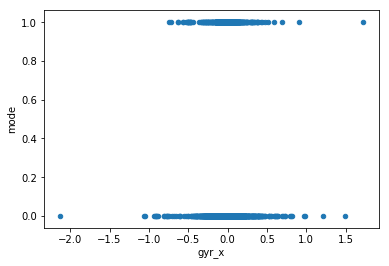

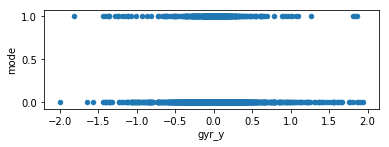

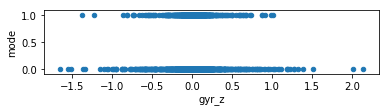

In [5]:
train_df.plot(x='gyr_x', y='mode', kind='scatter',subplots=True, layout=(1,1))
train_df.plot(x='gyr_y', y='mode', kind='scatter',subplots=True, layout=(2,1))
train_df.plot(x='gyr_z', y='mode', kind='scatter',subplots=True, layout=(3,1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4246313a90>],
      dtype=object)

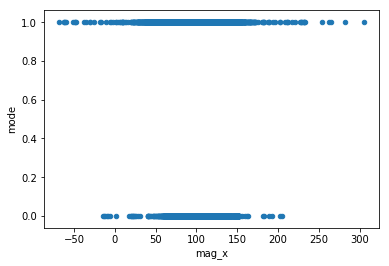

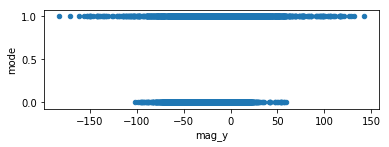

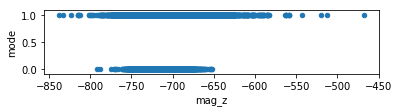

In [6]:
train_df.plot(x='mag_x', y='mode', kind='scatter',subplots=True, layout=(1,1))
train_df.plot(x='mag_y', y='mode', kind='scatter',subplots=True, layout=(2,1))
train_df.plot(x='mag_z', y='mode', kind='scatter',subplots=True, layout=(3,1))

## Pearson Coefficient (Correlation Measure)

Pearson Coefficient ranges between -1 to 1.

If two variables produce Pearson Coefficient of

-1 : Negatively correlated
0  : Not correlated
1  : Positively correlated
    
Note that Pearson Coefficient is only great at measuring linear correlation.
Non-linear correlation is not captured and require sophisticated algorithms.

In [7]:
h, p_coeff = list(train_df)[:-1], np.corrcoef(train_df[train_df.columns].T)[-1][:-1]

In [22]:
print("Feature : Pearson Coefficient between feature and mode")
pp.pprint(list(zip(h, p_coeff)))

Feature : Pearson Coefficient between feature and mode
[   ('acc_x', -0.05279564030281753),
    ('acc_y', 0.1634624475364774),
    ('acc_z', -0.39984482846970276),
    ('gyr_x', -0.008078989334541192),
    ('gyr_y', -0.014469707886927235),
    ('gyr_z', -0.013270017063360008),
    ('mag_x', -0.09362576143011761),
    ('mag_y', 0.48030095814623236),
    ('mag_z', -0.3930075181012833)]


In [9]:
test_df = pd.read_csv("./data/train_walk/merged_df12.csv")

In [10]:
test_df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,mode
0,-0.580500,-0.376912,-0.858185,0.823212,-1.272205,0.760356,88.629878,-347.511088,-323.177317,0
1,-0.642831,-0.447676,-0.008250,-0.581631,-1.967574,-0.177705,45.188577,-346.533356,-298.484753,0
2,-0.314315,-1.063927,0.219892,-0.520392,0.616227,-0.287383,57.942036,-359.657361,-285.999742,0
3,-0.795715,-0.616163,0.079114,0.049329,0.358394,0.319521,43.305013,-346.993262,-291.387979,0
4,-0.403455,-0.855800,0.079128,0.178603,-0.462796,-0.563583,62.322422,-357.947539,-292.615660,0


# Feature Generation

In [11]:
def gen_feat(df):

    df['acc_norm'] = np.linalg.norm(df[['acc_x','acc_y','acc_z']].values,axis=1)
    df['gyr_norm'] = np.linalg.norm(df[['gyr_x','gyr_y','gyr_z']].values,axis=1)
    df['mag_norm'] = np.linalg.norm(df[['mag_x','mag_y','mag_z']].values,axis=1)
    
    df['acc_mean'] = df[['acc_x','acc_y','acc_z']].mean(axis=1)
    df['gyr_mean'] = df[['gyr_x','gyr_y','gyr_z']].mean(axis=1)
    df['mag_mean'] = df[['mag_x','mag_y','mag_z']].mean(axis=1)
    
    df['acc_median'] = df[['acc_x','acc_y','acc_z']].median(axis=1)
    df['gyr_median'] = df[['gyr_x','gyr_y','gyr_z']].median(axis=1)
    df['mag_median'] = df[['mag_x','mag_y','mag_z']].median(axis=1)
    
    df['acc_var'] = df[['acc_x','acc_y','acc_z']].var(axis=1)
    df['gyr_var'] = df[['gyr_x','gyr_y','gyr_z']].var(axis=1)
    df['mag_var'] = df[['mag_x','mag_y','mag_z']].var(axis=1)
    
    return df

In [12]:
# Rearranging the 'model' column for convenience
train_df = gen_feat(train_df)

tmode = train_df['mode']
train_df.drop(columns=['mode'], inplace=True)
train_df['mode'] = tmode

In [13]:
test_df = gen_feat(test_df)

tmode = test_df['mode']
test_df.drop(columns=['mode'], inplace=True)
test_df['mode'] = tmode

In [14]:
train_df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,acc_norm,...,acc_mean,gyr_mean,mag_mean,acc_median,gyr_median,mag_median,acc_var,gyr_var,mag_var,mode
0,0.192784,-0.480037,-0.839129,-0.474434,-0.268126,0.283632,127.769066,12.484465,-772.170809,0.985768,...,-0.375461,-0.152976,-210.639093,-0.480037,-0.268126,12.484465,0.274413,0.153611,239811.036013,1
1,-0.078466,-0.026469,-0.996841,-0.111714,-0.246666,-0.244131,100.514932,29.385223,-775.509803,1.000274,...,-0.367259,-0.200837,-215.203216,-0.078466,-0.244131,29.385223,0.297956,0.005959,236722.462619,1
2,-0.051055,-0.108133,-0.997823,0.081890,0.113779,-0.092978,96.297213,34.125927,-770.516082,1.004963,...,-0.385670,0.034230,-213.364314,-0.108133,0.081890,34.125927,0.281863,0.012391,233779.886307,1
3,-0.010501,-0.128384,-1.008556,0.020765,-0.093513,0.003766,97.242038,34.374825,-770.246047,1.016749,...,-0.382480,-0.022994,-212.876395,-0.128384,0.003766,34.374825,0.297452,0.003802,233983.768773,1
4,-0.011499,-0.128213,-1.016252,0.022095,-0.094202,0.004144,97.645691,34.346363,-770.386385,1.024373,...,-0.385321,-0.022654,-212.798110,-0.128213,0.004144,34.346363,0.301961,0.003920,234180.214555,1


In [15]:
train_data = train_df.values
X_train, Y_train = train_data[:, :-1], train_data[:, -1]

In [16]:
test_data = test_df.values
X_test, Y_test = test_data[:, :-1], test_data[:, -1]

In [17]:
# Shuffle the train data to ensure data does not depend on sequence

train_data_shuf = train_df.values
np.random.shuffle(train_data_shuf)

X_train_shuf, Y_train_shuf = train_data_shuf[:, :-1], train_data_shuf[:, -1]

# Shuffle the test data
test_data_shuf = test_df.values
np.random.shuffle(test_data_shuf)

X_test_shuf, Y_test_shuf = test_data_shuf[:, :-1], test_data_shuf[:, -1]

# Random Forest Classifier And Performance Evaluation

Notice other than accuracy, both precision and recall with f1-score is added as part of the evaluation.

A common mistake commited when making binary-class classification lies in the fact that accuracy is solely used
as the evaluation metric.

Precision refers to percentage of obtained results relevant whereas recall refers to percentage of total relevant
results correctly classified by the algorithm.

Following explanation may help to clarify any confusion.

If we want to classify a fruit to be orange or apple, the following situation explains performance of classifier:

If result when determing orange has 
(1) Low Precision, Low Recall
- Classifier is performing poorly, and might be at best randomly guessing the output

(2) Low Precision, High Recall
- Classifier manages to classify many true oranges as orange but also classify significant amount of apples as true
oranges.

(3) High Precision, Low Recall
- Classifier is very strict when classifying the fruit. It manages to classify a lot of true oranges as oranges
but also choose NOT to classify some true oranges as oranges.

(4) High Precision, High Recall
- Best combination and ideal choice. 

Low Precision and Low Recall score may be defined somewhere between 0.5 - 0.7.
Anything lower than 0.5 should be inspected as this indicates the classifier performs worst than random guess
which is normally not a random error but faulty data collection or processing.

High Precision and High Recall score may be defined somewhere between 0.7 - 0.9.
Any value around 0.9 or higher should be treated carefully as there is a high tendency to be overfitting.

In [ ]:
# Grid search across range of parameters to tune Random Forest Classifier
# Store each Random Forest Classifer object and retrieve the best performing one
depths = (2, 5, 8, 10, 15)
n_estimators = (10, 50, 100, 150, 200)

target_names = ('Walk', 'Train')

rclfs = {}

for d in depths:
    for n in n_estimators:
        print(f"Tree depth : {d}. n_estimators: {n}.")
        
        # Create RandomForestClassifier and fit the data
        rclf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=0)
        rclf.fit(X_train_shuf, Y_train_shuf)
        
        Y_pred = rclf.predict(X_test_shuf)
        print(f"Accuracy is {(Y_pred == Y_test_shuf).mean()}%.")
        
        average_precision = average_precision_score(Y_test_shuf, Y_pred)
        print(average_precision)"
        print(classification_report(Y_test_shuf, Y_pred, target_names=target_names))
        
        rclfs[f'd{d}n{n}'] = rclf

# Feature Importance

RandomForest Classifier by default generates feature importance score which can be convenient to inspect
the weightage of each feature carries to produce the results.

In [25]:
tdf_h = list(train_df)[:-1]
pp.pprint(list(zip(tdf_h, rclf.feature_importances_)))

[   ('acc_x', 0.043646621075614546),
    ('acc_y', 0.1141890327692851),
    ('acc_z', 0.07069741414324815),
    ('gyr_x', 0.00128278407793011),
    ('gyr_y', 0.004956939820610673),
    ('gyr_z', 0.002353014479600909),
    ('mag_x', 0.014604168928079227),
    ('mag_y', 0.08158616979542622),
    ('mag_z', 0.047161587524729376),
    ('acc_norm', 0.04640629775421443),
    ('gyr_norm', 0.15870774881341576),
    ('mag_norm', 0.03390433542894917),
    ('acc_mean', 0.059416443939478245),
    ('gyr_mean', 0.004885895191431283),
    ('mag_mean', 0.01853134927049476),
    ('acc_median', 0.014831250031325913),
    ('gyr_median', 0.002188239944104385),
    ('mag_median', 0.07131075422818461),
    ('acc_var', 0.03745922707610609),
    ('gyr_var', 0.06872197652955765),
    ('mag_var', 0.10315874917821358)]


# Results 

Tree depth : 5. n_estimators: 150.

Accuracy is 0.8508711991800478 or 85.08%.

Average precision score is 0.8330248206874856.
              
                precision    recall  f1-score   support

        Walk       0.88      0.66      0.75      2001
       Train       0.84      0.95      0.89      3853

   micro avg       0.85      0.85      0.85      5854

   macro avg       0.86      0.80      0.82      5854
    
weighted avg       0.85      0.85      0.84      5854

# Conclusion

Our classifier produces high precision and high recall on Train which is great.

However, it has high precision and low recall in Walk. The strong correlation of Walk in accelerometer readings
indicate we can take advantage of this. Either more data can be gathered to further improve the accuracy or
some noise filtering method can be applied on the data itself.